# Retina image classification

In [2]:
## Get data ready from google colab:
#!rm -rf *
#!git clone https://github.com/yiweichen04/retina_dataset.git
#!git clone https://github.com/stacyxuliwen/NICF_Deep-learning.git

#!mkdir imageAug
#!mv NICF_Deep-learning/*/*.py imageAug
#!rm NICF* -rf

This work was done for the NICF course: Feature Extraction and Supervised Modeling with Deep Learning (SF) with Ms. Lisa ONG and Dr Abhinit Ambastha, two lovely lecturers who made the difficult classes intuitive enough to access and full of details to digest. 

In this notebook we are targeted to use deep learning methods to aid classification of different eye diseases from Fundus images. Due to largely available existing industry-standard models, we are adapting our model from one of the kaggle models with similar tasks for Diabetic Retinopathy Detection. 

We are doing a transfer learning from existing gold standard ImageNet applications from keras models.

## Model and data

We will be looking at eye disease images in this notebook, with normal, cataract, glaucoma and retina related diseased eyes. 

Cataract eyes are with clouds in the eye images, glaucoma will have different ratios of optic disk spaces compared to normal patients and retina images are with additional or tumor grown on the eye blood vessels observed in the fundus images.

Below is a description of the data input and model input. We used 2 models for this work. Both were able to handle fundus image classifications in different eye diseases.

### Source model domain 1 

- Fundus images from Diabetic Retinopathy (DR) Detection by Kevin Mader: https://www.kaggle.com/c/diabetic-retinopathy-detection/data

- Degree of severity of Diabetic retina:
        0 - No DR
        1 - Mild
        2 - Moderate
        3 - Severe
        4 - Proliferative DR
        
- 35126 training / validation images
- 512 x 512 x 3
- Selected Architecture
  - Inception V3 + attention model selected at: 
  https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr

### Source model domain 2

- Proved best for glaucoma image identification by Dr Ryo Asaoka etc: https://www.ophthalmologyglaucoma.org/article/S2589-4196(19)30061-4/fulltext
- Resnet model from keras
- Imagenet challanges
- 224 x 224 x 3

### Target domain

- Four types of eye diseases: https://github.com/yiweichen04/retina_dataset/tree/master/dataset
- Data composition:
    - Normal eyes: 300
    - Cataract eyes: 100
    - Glaucoma eyes: 101
    - Eyes with retina diseases: 100
    - Classes are not part of ImageNet
    - Input dimensions do not change from source network
  
- Architecture
  - Inception_v3 + attention model with CNN featurizer
  - Train own classifier
  - Optionally fine-tune by freezing most layers and unfreezing the rest
Fundus images from target look below with either left and right eyes (resized to show):
<img src="retina_dataset/dataset/1_normal/NL_002.png" alt="Drawing" style="width: 200px;"/>


### Other resources

* This work refers to the (slightly modified) pre-process of retina images by Dr. Graham's https://www.kaggle.com/c/diabetic-retinopathy-detection/discussion/15801 and implemented here https://github.com/usuyama/pydata-medical-image/blob/master/diabetic_retinopathy/scripts/preprocess.py. 
 - Estimate radius of the circle
 - Resize all images
 - Crop to squares
 - Subtracted the local average color with more focus / attention: the local average gets mapped to 50% gray
 - Remove outer boundary (keep 90%)
 

* This work generated augmentated image dataset with modified version of keras' ImageDataGenerator with histogram balancer here https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085.


* We used training split utility from https://github.com/kouml/keras-split-utils to be used with above image data generator.

## Processes

Our analysis workflow is as follows:

For the data:

* Preprocess was done with the above mentioned method before the data enter any model to crop and focus all the images. 
* Data augmentation was done to avoid overfitting since our number of images are relatively small.
* Class weights was assigned to handle imbalanced datasets.

For the model:

* We will fit both source model 1 with InceptionV3 and 2 with Resnet.

For the evaluation:

* We will check the accuracy of the class predictions of the eye images.
* We will access whether the model helps improve from baseline estimation of 50% for normal eyes (by assuming all are normal eyes), and 16.7% for each type of diseased eyes (by assuming all are with each disease type).


### Load packages

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
from skimage.io import imread # io related
import os
from glob import glob
import time
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score # evaluation metric
from tqdm import tqdm_notebook ##### create one fixed dataset for evaluating
import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input
from keras.applications.xception import preprocess_input
import numpy as np
from collections import Counter # to calculate class weight
from IPython.display import SVG # plot model diagram
from keras.utils.vis_utils import model_to_dot # plot model diagram

from keras.preprocessing.image import image # Image loading and augmentation ImageDataGenerator
from keras.models import Sequential, Model, load_model # Target network's classifier
from keras.layers import Flatten, Dense, Dropout, LeakyReLU, ReLU
from keras.layers import GlobalAveragePooling2D, Input, Conv2D, multiply
from keras.layers import BatchNormalization, LocallyConnected2D, Lambda, InputLayer
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint # training
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.optimizers import SGD, Adam
from keras.applications import inception_v3, ResNet50 # Source network, AlexNet is in pytorch, resnet: 224 x 224
from keras.metrics import top_k_categorical_accuracy
from keras.utils.np_utils import to_categorical
from keras.regularizers import l1
import keras.backend as K

%matplotlib inline

Using TensorFlow backend.


### Look at original images

In [5]:
# We look at target image size
# The target image size is similar as the original source image size, both not square

img_path = 'retina_dataset/dataset/1_normal/NL_002.png' # fix this path to match yours
img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x)
x.shape

(1, 1632, 2464, 3)

In [0]:
# Use inception_v3 as baseline model, 299
img_height=512
#img_width=512
channels=3

In [7]:
# preprocess input
img = image.load_img(img_path, target_size=(img_height, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x)
x.shape

(1, 512, 512, 3)

W0813 15:29:42.608592 140021887780736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


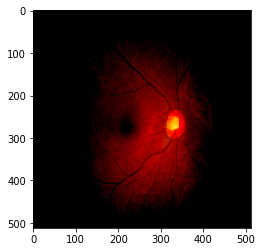

In [8]:
plt.imshow(x.reshape(img_height, img_height, 3))

### Preprocess images outside the models

Preprocess follows the following steps:

- Estimate radius of the circle
- Resize all images
- Crop to squares
- Subtracted the local average color with more focus / attention: the local average gets mapped to 50% gray
- Remove outer boundary (keep 90%)

Processed images are stored in a new directory to be read.

In [0]:
# Preprocess images and put in another directory
from imageAug.retina_preprocess import *
input_path = "retina_dataset/dataset"

train_files = glob.glob(os.path.join(input_path, "*", "*.png"))
out_directory = "retina_dataset/processed"
if not os.path.exists(out_directory):
    os.makedirs(out_directory)

In [0]:
# batch process images
from joblib import Parallel, delayed
# We modify the code to keep directory structures
# Note there are many cataract images with low contrast
Parallel(n_jobs=6)(delayed(process_and_save)(f, out_directory) for f in train_files);

W0813 15:30:29.744131 140021887780736 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


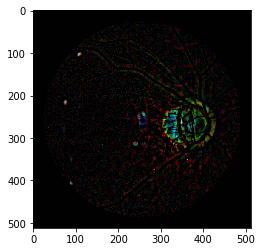

In [11]:
# show the same processed image
img_path = 'retina_dataset/processed/2_glaucoma/Glaucoma_005.png'
img = image.load_img(img_path)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x)
plt.imshow(x.reshape(img_height, img_height, 3))

### Obtain training and validation datasets

We rescaled the images and added a 20% rotation and horizontal flip for image augmentation.

80% of the images are used for training and 20% are used for validation.

In [0]:
#from imageAug.image_aug_contrast import *
#from imageAug.split_utils import *
original_dir = 'retina_dataset/processed'
#validation_split = 0.2
#base_dir, train_dir, val_dir = train_valid_split(original_dir, validation_split, seed=1250)


In [13]:
from keras_preprocessing.image import ImageDataGenerator

train_dir = 'retina_dataset/processed'
# Load images from folder (ImageDataGenerator), with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.2,
    rotation_range=0.2, # we adjust for the rotation range since the retina images do not always rotate
    #zca_whitening=True,
    horizontal_flip=True,
    #channel_shift_range=8,
    preprocessing_function=inception_v3.preprocess_input,
    validation_split = 0.2 # set validation split
    #contrast_stretching = False
)    

X_train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=128, # ran out of ram if batch size too big
    subset='training'
) 

#val_datagen = ImageDataGenerator(
#    rescale=1./255,
#    preprocessing_function=inception_v3.preprocess_input)   

X_val_gen = train_datagen.flow_from_directory(
    #val_dir,
    train_dir,
    target_size=(512, 512),
    batch_size=64,
    subset='validation'
) 

X_train_gen.class_indices

Found 481 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}

### Fit model using InceptionV3

We first try the adapted model from a previous kaggle entry by Kevin Mader with addition of attention layer of 'global weighted average pooling' to focus on the specific features for a particular class: https://www.kaggle.com/kmader/inceptionv3-for-retinopathy-gpu-hr. 

In [15]:
# Predict
# try Xception model result
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)
xcep_model = load_model('full_retina_model.h5', 
                        custom_objects={'top_2_accuracy': top_2_accuracy})

xcep_model.summary()

W0813 15:41:04.661160 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 15:41:04.737183 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 15:41:04.774911 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 15:41:04.775951 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0813 15:41:04.778288 140021887

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [16]:
for layer in xcep_model.layers:
    print(layer.output_shape)

(None, 512, 512, 3)
(None, 14, 14, 2048)
(None, 14, 14, 2048)
(None, 14, 14, 2048)
(None, 14, 14, 64)
(None, 14, 14, 16)
(None, 14, 14, 8)
(None, 14, 14, 1)
(None, 14, 14, 2048)
(None, 14, 14, 2048)
(None, 2048)
(None, 2048)
(None, 2048)
(None, 2048)
(None, 128)
(None, 128)
(None, 5)


In [17]:
# random select to check
img_path = original_dir + '/3_retina_disease/Retina_058.png'
img = image.load_img(img_path, target_size=(512, 512))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x)
x.shape

# 2 is retina, not too bad, identified as retina 
xcep_model.predict(x).argmax(axis = 1)

array([2])

In [18]:
# classifier
clf = Sequential()

clf.add(InputLayer(input_shape=(128,)))
clf.add(Dense(4, activation='softmax'))

clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 516       
Total params: 516
Trainable params: 516
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Extract Imagenet CNN features
model = xcep_model
model.layers[:-1]

In [20]:
# remove top layer
model1 = xcep_model
model1.layers.pop()
model2 = Model(model1.input, model1.layers[-1].output)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [21]:
clf_output = clf(model2.output) # classifier consumes the output of the CNN
combined_model = Model(inputs=model2.input, # CNN without classifier
                       outputs=clf_output) # classifier
combined_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 14, 14, 2048) 21802784    input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 14, 14, 2048) 8192        inception_v3[1][0]               
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 2048) 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_95 

In [22]:
combined_model.layers[:-10]

In [0]:
# Freeze layers up to the classifier
# This will preserve the weights for layers during backpropagation
for layer in combined_model.layers[:-10]:
    layer.trainable = False # freeze

#combined_model.summary()

We assigned class weights to balance the dataset.

In [24]:
# balance training.
counter = Counter(X_train_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

class_weights

{0: 1.0, 1: 3.0, 2: 2.962962962962963, 3: 3.0}

In [0]:
tb = TensorBoard(log_dir='./logs/transfer_attention/{}'.format(str(time.ctime())))
es = EarlyStopping(patience=10)
mc = ModelCheckpoint('transfer_attention.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True)



In [0]:
# Train the combined model
combined_model.compile(optimizer=Adam(lr=1e-3), # or 1e-4
                       loss='categorical_crossentropy',
                       metrics=['acc'])


In [27]:
history = combined_model.fit_generator(
        X_train_gen,
        steps_per_epoch=8,
        epochs=20,
        validation_data=X_val_gen,
        validation_steps=8,
        #workers = 2,
        callbacks=[tb, es, mc],
        class_weight = class_weights)

W0813 15:41:50.047713 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0813 15:41:50.049111 140021887780736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



Epoch 1/20
8/8 [==============================] - 97s 12s/step - loss: 2.4291 - acc: 0.3751 - val_loss: 1.6824 - val_acc: 0.1729

Epoch 00001: val_loss improved from inf to 1.68242, saving model to transfer_attention.01-1.68.hdf5
Epoch 2/20
8/8 [==============================] - 46s 6s/step - loss: 1.8281 - acc: 0.5715 - val_loss: 1.6648 - val_acc: 0.1667

Epoch 00002: val_loss improved from 1.68242 to 1.66484, saving model to transfer_attention.02-1.66.hdf5
Epoch 3/20
8/8 [==============================] - 63s 8s/step - loss: 1.4913 - acc: 0.6650 - val_loss: 1.9766 - val_acc: 0.1667

Epoch 00003: val_loss did not improve from 1.66484
Epoch 4/20
8/8 [==============================] - 62s 8s/step - loss: 1.3216 - acc: 0.7216 - val_loss: 2.1090 - val_acc: 0.1667

Epoch 00004: val_loss did not improve from 1.66484
Epoch 5/20
8/8 [==============================] - 62s 8s/step - loss: 1.1906 - acc: 0.7602 - val_loss: 2.1345 - val_acc: 0.1667

Epoch 00005: val_loss did not improve from 1.664

The learning curve diverges after 10 epoches.

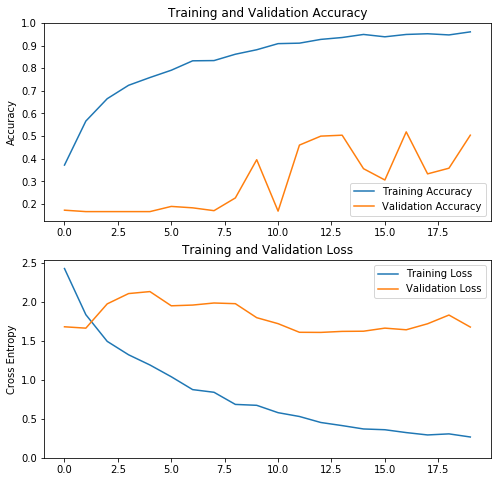

In [28]:
# learning curve
acc = history.history['acc']

val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()



In [0]:
# May be due to the complexity, not able to continue after loading the model, stop here.

#from keras.optimizers import RMSprop
#model_path = 'transfer_attention.13-1.61.hdf5' 
#b_model = load_model(model_path)

#b_model.compile(optimizer=Adam(lr=1e-4), # change optimizer after loading the model
#                       loss='categorical_crossentropy',
#                       metrics=['acc'])
# backpropogation may not be working if model not learning anything
#history_fine = b_model.fit_generator(
#        X_train_gen,
#        steps_per_epoch=8,
#        epochs=20,
#        validation_data=X_val_gen,
#        validation_steps=8,
#        #workers = 4,
#        callbacks=[tb, es, mc])

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


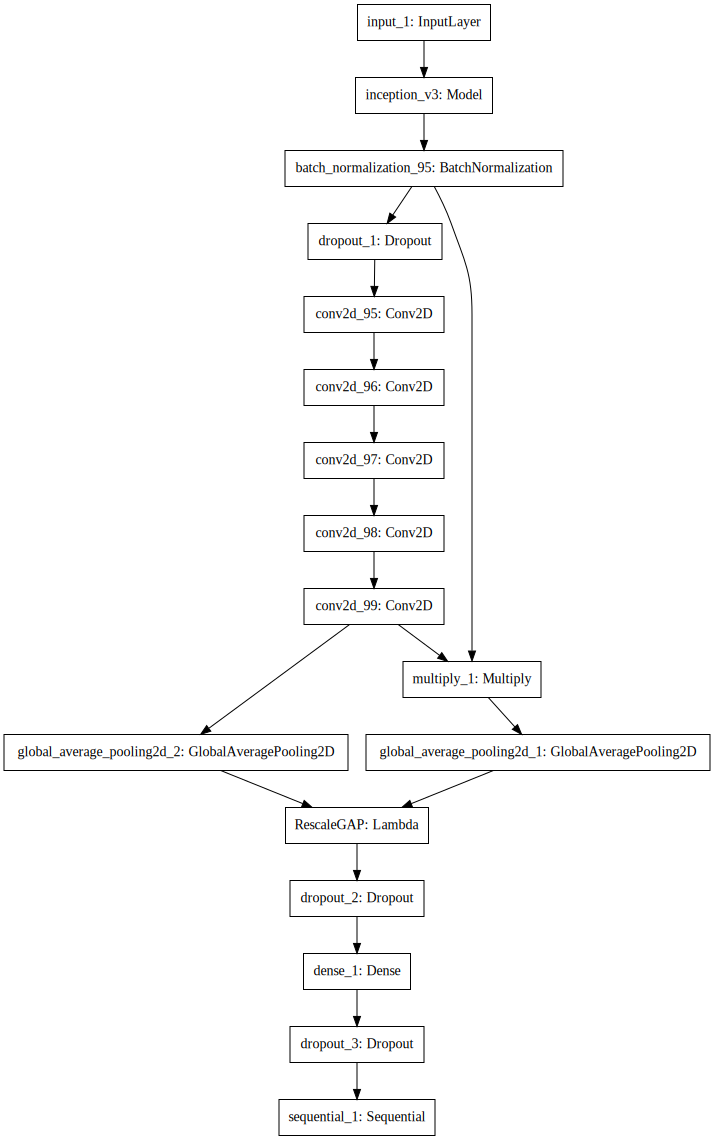

In [31]:
# find model with lowest val loss
model_path = 'transfer_attention.13-1.61.hdf5' # update model path
best_model = load_model(model_path)

SVG(model_to_dot(best_model).create(prog='dot', format='svg'))

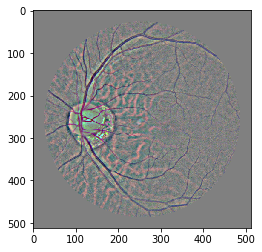

In [35]:
# ### Predict
# load a picture from validation dataset
img_path = original_dir + '/1_normal/NL_008.png'
img = image.load_img(img_path, target_size=(img_height, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x) # change to mobilenet if needed
plt.imshow(img)


In [37]:
best_model.predict(x)

array([[0.06757934, 0.03034795, 0.6330582 , 0.26901457]], dtype=float32)

In [38]:
# where to get the inferred class names
X_train_gen.class_indices


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}

In [39]:
# decode predictions
best_model.predict(x).argmax(axis=1)


array([2])

In [40]:
# ### Metrics
X_val, y_val = X_val_gen.next()
y_val_classes = y_val.argmax(axis=1)
y_val_classes


array([0, 0, 0, 3, 3, 2, 3, 3, 2, 0, 2, 2, 0, 2, 3, 1, 0, 2, 1, 1, 1, 0,
       0, 0, 0, 2, 2, 1, 2, 3, 0, 3, 0, 0, 3, 0, 0, 0, 1, 1, 2, 2, 3, 1,
       0, 3, 0, 0, 3, 0, 0, 3, 3, 0, 0, 0])

In [41]:
# probabilities
pred = best_model.predict(X_val)

# probabilities to classes
pred_classes = pred.argmax(axis=1)
pred_classes


array([0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 0,
       0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0])

Confusion matrix is shown. Only normal and glaucoma eyes are detected.

In [43]:
print(classification_report(y_val_classes, pred_classes))


              precision    recall  f1-score   support

           0       0.61      0.83      0.70        24
           1       0.00      0.00      0.00         8
           2       0.26      0.55      0.35        11
           3       0.00      0.00      0.00        13

    accuracy                           0.46        56
   macro avg       0.22      0.34      0.26        56
weighted avg       0.31      0.46      0.37        56



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [44]:
print(confusion_matrix(y_val_classes, pred_classes))


[[20  0  4  0]
 [ 1  0  7  0]
 [ 5  0  6  0]
 [ 7  0  6  0]]


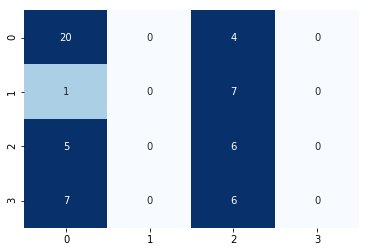

In [45]:
sns.heatmap(confusion_matrix(y_val_classes, pred_classes), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)


We also show the PCA after different layers.

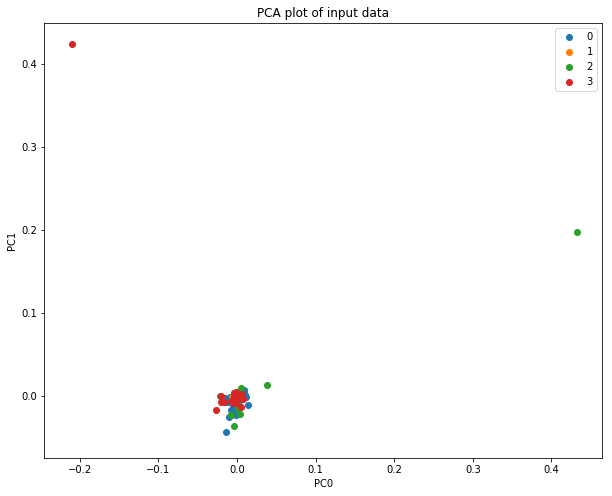

In [46]:
from sklearn.decomposition import PCA

img_rows = 512
img_cols = 512
num_classes = 4

X_train, y_train = X_train_gen.next()
# flatten from 60000,28,28 to 60000,784
X_train_flattened = X_train.reshape(-1, img_cols*img_rows*3)

pca_input = PCA(n_components=2)
Z_train_2d = pca_input.fit_transform(X_train_flattened)

fig, ax = plt.subplots(figsize=(10, 8))

# convert one-hot to categorical
y_train_cat = y_train.argmax(axis=1)

for c in range(num_classes):
    mask = (y_train_cat == c)
    ax.scatter(Z_train_2d[mask, 0], Z_train_2d[mask, 1], label=c)
    
ax.legend()
ax.set_title('PCA plot of input data')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
plt.show()

In [47]:
best_model.layers

(128, 14, 14, 16)
(128, 3136)


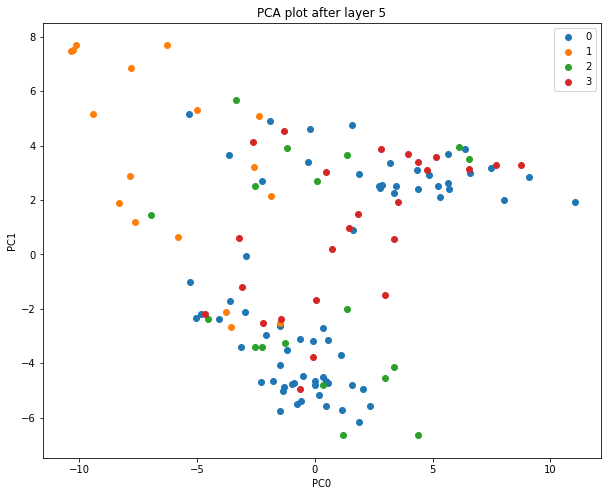

In [52]:
def plot_data(layer_index, data, labels):
    int_model = Model(inputs=best_model.input,
                      outputs=best_model.layers[layer_index].output)

    features = int_model.predict(data)
    print(features.shape)
    features = features.reshape(features.shape[0],-1)
    print(features.shape)

    pca_input = PCA(n_components=2)
    Z_2d = pca_input.fit_transform(features)

    fig, ax = plt.subplots(figsize=(10, 8))

    for c in range(num_classes):
        mask = (labels == c)
        ax.scatter(Z_2d[mask, 0], Z_2d[mask, 1], label=c)
    
    ax.legend()
    ax.set_title(f'PCA plot after layer {layer_index}')
    ax.set_xlabel('PC0')
    ax.set_ylabel('PC1')
    plt.show()
    
# index 3 after Flatten
plot_data(5, X_train, y_train.argmax(axis=1))

(128, 128)
(128, 128)


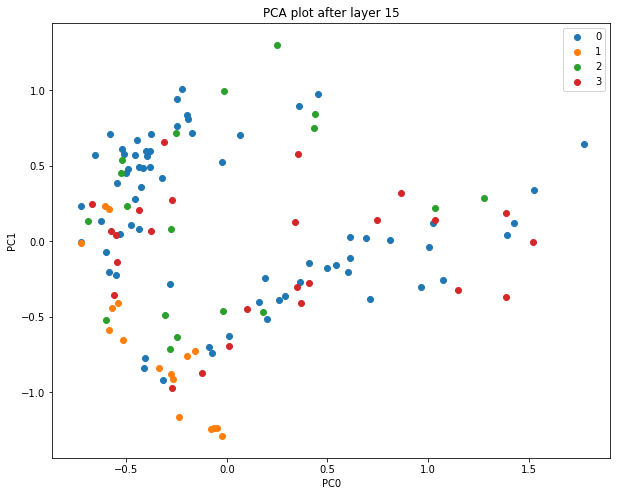

In [57]:
plot_data(15, X_train, y_train.argmax(axis=1))

There are 2 problems with the Inception V3 + attention models with this dataset. 

1. It seems that the newer layers learned from this model are just rotating the PCAs. With less amount of samples, it may make sense to use a simpler model. 

2. This model learns well on normal and glaucoma instances. It identified 20 out of 24 normal eyes and 6 out of 11 glaucoma eyes. We may use some part of the inception V3 model to fit with normal versus glaucoma eyes and use other modesl to fit the othe diseases.

### Refit model using ResNet

ResNet has been proven to be good for identification of Glaucoma images by Dr Ryo Asaoka etc: https://www.ophthalmologyglaucoma.org/article/S2589-4196(19)30061-4/fulltext.

We follow the same process with InceptionV3 + Attention models as ResNet.

In [66]:
# We repeat the same with ResNet, a smaller network
img_height = 224
# Extract Imagenet CNN features
# Load the model without the classifier
model = ResNet50(input_shape=(img_height, img_height, channels), include_top=False)
model.summary()
#pop_layer(model)


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [64]:
# classifier
clf = Sequential()

# The shapes at the top must match the final layer from the model
# So that we can attach the classifier

clf.add(InputLayer(input_shape=(7, 7, 2048))) 
clf.add(Flatten())

clf.add(Dense(64*2, activation='relu', activity_regularizer=l1(0.001)))
clf.add(BatchNormalization())
clf.add(Dropout(0.2))

#clf.add(Dense(64*2, activity_regularizer=l1(0.001)))
#clf.add(ReLU(alpha=0.05))
#clf.add(Dropout(0.2))

clf.add(BatchNormalization())
clf.add(Dense(64, activation='relu', activity_regularizer=l1(0.001)))

clf.add(Dense(4, activation='softmax'))



clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               12845184  
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total para

In [67]:
clf_output = clf(model.output) # classifier consumes the output of the CNN
combined_model = Model(inputs=model.input, # CNN without classifier
                       outputs=clf_output) # classifier
combined_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
# Freeze layers up to the classifier
for layer in combined_model.layers[:-5]:
    layer.trainable = False # freeze


In [0]:
combined_model.compile(optimizer=Adam(lr=1e-3), # or 1e-4
                       loss='categorical_crossentropy',
                       metrics=['acc'])


In [70]:
counter = Counter(X_train_gen.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

class_weights


{0: 1.0, 1: 3.0, 2: 2.962962962962963, 3: 3.0}

In [0]:
tb = TensorBoard(log_dir='./logs/transfer_resnet/{}'.format(str(time.ctime())))
es = EarlyStopping(patience=10)
mc = ModelCheckpoint('transfer_resnet.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True)


In [73]:
X_train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    subset='training'
) 

X_val_gen = train_datagen.flow_from_directory(
    #val_dir,
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    subset='validation'
) 

Found 481 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [74]:
history = combined_model.fit_generator(
        X_train_gen,
        steps_per_epoch=10,
        epochs=200,
        validation_data=X_val_gen,
        validation_steps=10,
        #workers = 4,
        callbacks=[tb, es, mc],
        class_weight = class_weights)


Epoch 1/200
10/10 [==============================] - 37s 4s/step - loss: 4.7640 - acc: 0.2691 - val_loss: 2.5838 - val_acc: 0.1667

Epoch 00001: val_loss improved from inf to 2.58384, saving model to transfer_resnet.01-2.58.hdf5
Epoch 2/200
10/10 [==============================] - 7s 690ms/step - loss: 2.8505 - acc: 0.1834 - val_loss: 2.5763 - val_acc: 0.1667

Epoch 00002: val_loss improved from 2.58384 to 2.57633, saving model to transfer_resnet.02-2.58.hdf5
Epoch 3/200
10/10 [==============================] - 18s 2s/step - loss: 2.8029 - acc: 0.1671 - val_loss: 2.5681 - val_acc: 0.1667

Epoch 00003: val_loss improved from 2.57633 to 2.56814, saving model to transfer_resnet.03-2.57.hdf5
Epoch 4/200
10/10 [==============================] - 22s 2s/step - loss: 2.7596 - acc: 0.1669 - val_loss: 2.5563 - val_acc: 0.1667

Epoch 00004: val_loss improved from 2.56814 to 2.55630, saving model to transfer_resnet.04-2.56.hdf5
Epoch 5/200
10/10 [==============================] - 23s 2s/step - los

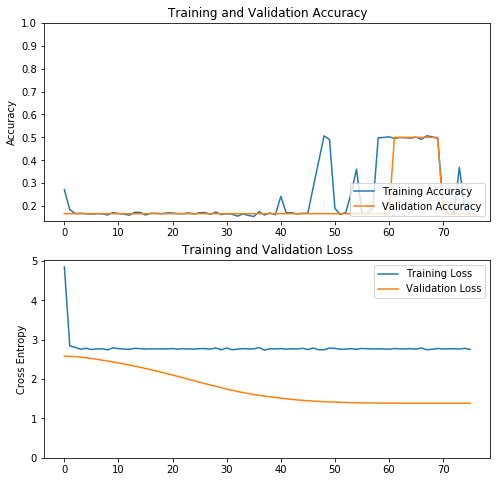

In [75]:
# learning curve
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()


In [76]:
model_path = 'transfer_resnet.66-1.39.hdf5' 
combined_model = load_model(model_path)

combined_model.compile(optimizer=Adam(lr=1e-4), # change optimizer after loading the model
                       loss='categorical_crossentropy',
                       metrics=['acc'])
# backpropogation may not be working if model not learning anything
history_fine = combined_model.fit_generator(
        X_train_gen,
        steps_per_epoch=8,
        epochs=50,
        validation_data=X_val_gen,
        validation_steps=8,
        workers = 4,
        callbacks=[tb, es, mc],
        class_weight = class_weights)


Epoch 1/50
8/8 [==============================] - 35s 4s/step - loss: 2.7682 - acc: 0.4985 - val_loss: 1.3856 - val_acc: 0.4896

Epoch 00001: val_loss did not improve from 1.38540
Epoch 2/50
8/8 [==============================] - 6s 807ms/step - loss: 2.7796 - acc: 0.4944 - val_loss: 1.3855 - val_acc: 0.5188

Epoch 00002: val_loss did not improve from 1.38540
Epoch 3/50
8/8 [==============================] - 18s 2s/step - loss: 2.7300 - acc: 0.5122 - val_loss: 1.3856 - val_acc: 0.4917

Epoch 00003: val_loss did not improve from 1.38540
Epoch 4/50
8/8 [==============================] - 17s 2s/step - loss: 2.7763 - acc: 0.4955 - val_loss: 1.3856 - val_acc: 0.4833

Epoch 00004: val_loss did not improve from 1.38540
Epoch 5/50
8/8 [==============================] - 17s 2s/step - loss: 2.7873 - acc: 0.4916 - val_loss: 1.3855 - val_acc: 0.5146

Epoch 00005: val_loss did not improve from 1.38540
Epoch 6/50
8/8 [==============================] - 16s 2s/step - loss: 2.7725 - acc: 0.4969 - val_l

In our case with fine tuning with a smaller learning rate does not help with loss improvement.

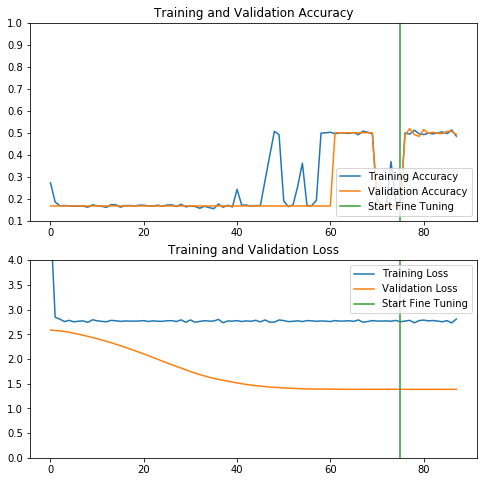

In [77]:
epochs = 76
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.1, 1])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4])
plt.plot([epochs-1,epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


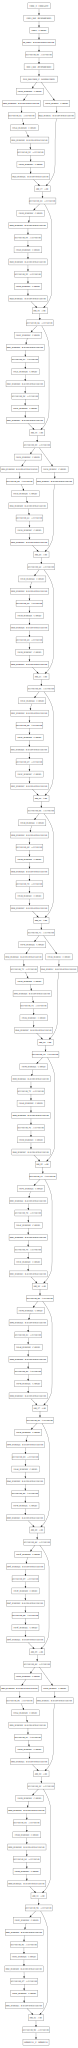

In [78]:
# find model with lowest val loss
model_path = 'transfer_resnet.66-1.39.hdf5' # update model path
best_model = load_model(model_path)

SVG(model_to_dot(best_model).create(prog='dot', format='svg'))


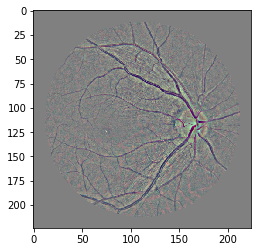

In [79]:
# load a picture from validation dataset
img_path = original_dir + '/1_normal/NL_007.png'
img = image.load_img(img_path, target_size=(img_height, img_height))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = inception_v3.preprocess_input(x) # change to mobilenet if needed
plt.imshow(img)


In [80]:
best_model.predict(x)


array([[0.2512038 , 0.24998999, 0.24918652, 0.24961971]], dtype=float32)

In [81]:
print(X_train_gen.class_indices)

# decode predictions
best_model.predict(x).argmax(axis=1)


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}


array([0])

In [82]:
# ### Metrics
X_val, y_val = X_val_gen.next()
y_val_classes = y_val.argmax(axis=1)
y_val_classes


array([0, 0, 1, 0, 3, 2, 0, 3, 0, 0, 0, 0, 2, 0, 0, 2, 3, 0, 3, 1, 2, 0,
       1, 2, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 3, 2, 3, 0, 0, 2, 0,
       0, 2, 0, 3, 1, 0, 0, 0, 1, 0, 3, 2, 3, 2, 2, 0, 0, 1, 0, 0])

In [83]:
# probabilities
pred = best_model.predict(X_val)

# probabilities to classes
pred_classes = pred.argmax(axis=1)
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

All predictions points to the same class! It could be due to imbalanced dataset. If we have time we could try downsample the normal eyes and see whether it improves the ResNet model.

In [84]:
print(classification_report(y_val_classes, pred_classes))


              precision    recall  f1-score   support

           0       0.52      1.00      0.68        33
           1       0.00      0.00      0.00        10
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00         9

    accuracy                           0.52        64
   macro avg       0.13      0.25      0.17        64
weighted avg       0.27      0.52      0.35        64



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


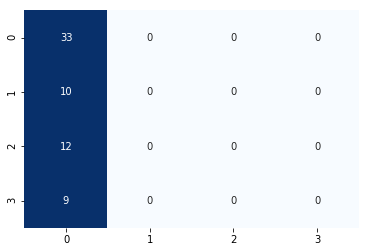

In [85]:
sns.heatmap(confusion_matrix(y_val_classes, pred_classes), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = X_val.shape[0]//16)

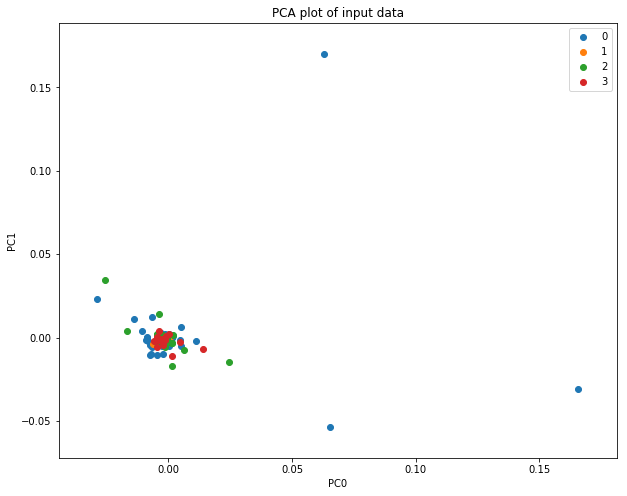

In [86]:
from sklearn.decomposition import PCA

img_rows = 224
img_cols = 224
num_classes = 4

X_train, y_train = X_train_gen.next()
# flatten from 60000,28,28 to 60000,784
X_train_flattened = X_train.reshape(-1, img_cols*img_rows*3)

pca_input = PCA(n_components=2)
Z_train_2d = pca_input.fit_transform(X_train_flattened)

fig, ax = plt.subplots(figsize=(10, 8))

# convert one-hot to categorical
y_train_cat = y_train.argmax(axis=1)

for c in range(num_classes):
    mask = (y_train_cat == c)
    ax.scatter(Z_train_2d[mask, 0], Z_train_2d[mask, 1], label=c)
    
ax.legend()
ax.set_title('PCA plot of input data')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
plt.show()

In [87]:
len(best_model.layers)

176

(128, 14, 14, 1024)


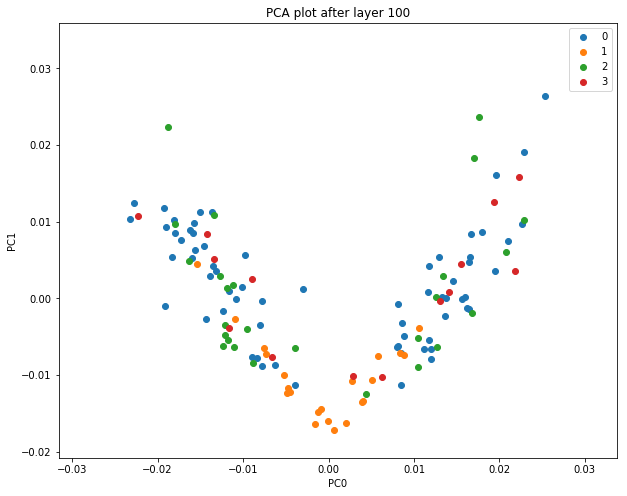

In [93]:
def plot_data(layer_index, data, labels):
    int_model = Model(inputs=best_model.input,
                      outputs=best_model.layers[layer_index].output)

    features = int_model.predict(data)
    print(features.shape)
    features = features.reshape(features.shape[0],-1)

    pca_input = PCA(n_components=2)
    Z_2d = pca_input.fit_transform(features)

    fig, ax = plt.subplots(figsize=(10, 8))

    for c in range(num_classes):
        mask = (labels == c)
        ax.scatter(Z_2d[mask, 0], Z_2d[mask, 1], label=c)
    
    ax.legend()
    ax.set_title(f'PCA plot after layer {layer_index}')
    ax.set_xlabel('PC0')
    ax.set_ylabel('PC1')
    plt.show()
    
# index 174 after Flatten
plot_data(100, X_train, y_train.argmax(axis=1))

(128, 7, 7, 2048)


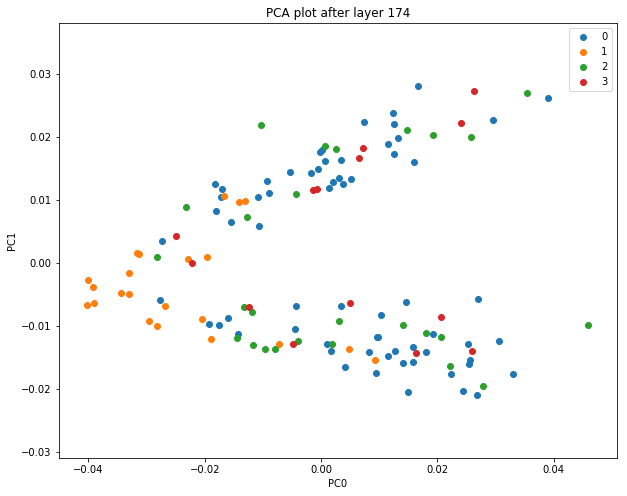

In [92]:
plot_data(174, X_train, y_train.argmax(axis=1))

From the above models, we observe that ResNet starts with a higher loss but converges faster. Each loop runtime is shorter for ResNet compared to InceptionV3 + Attention models. The final loss is also smaller for ResNet models compared to InceptionV3 + Attention models. For this set of run, 1e-03 is a good learning rate. 1e-02 gives non-converging results and 1e-04 is too slow to help with the gradient descent.

## Discussions

The accuracy of the mentioned network structures do not apply well on this dataset. It could be that we do not have enought time or enough samples to further tune the models to fit the purpose of multi-class identifications. 

There may be other good methods to overcome the imbalanced dataset problems we have here besides using class_weights in keras. 

Our dataset comes from github and there is no additional annotation. It is possible that some patients are with multiple conditions and some eyes are with more severe disease conditions compared to others. It may be also good to do multi-class analysis besides the softmax analysis that restrict the classes to fall in only one condition.

Further improvement and extension of the methods could be 

1. Model with disease versus normal, and model with different diseases to see whether results improve.
3. Automatically rotate the images to align with the same direction and apply CNN.
2. Segmentation and mark on the veins and major blood vessels using the images.
4. Make use of curvelet transform coefficients to enhance the retinal image edges to help segmentation.
5. Since the retina images are all round with vessles, vains and arteries, we may not need to look at big features.
6. Some people start using attention model to improve and focus on the important areas of the images.
7. Proper pre-processing may help improve model performance.

